In [1]:
!pip install -U efficientnet

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from skimage.io import MultiImage,imsave,imread
from skimage.transform import resize,rescale
from skimage.color import rgb2gray
from keras.layers import Input,Cropping2D,GlobalAveragePooling2D,Concatenate,Dense,Conv2D
from keras.models import Model,load_model
import keras.applications as kl
from keras.backend import name_scope
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm
import tensorflow as tf
from keras.utils import Sequence
from keras.optimizers import Adam,Adamax
from sklearn.utils import shuffle,class_weight
from keras.utils import to_categorical
import efficientnet.keras as efn

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose
)

Using TensorFlow backend.


In [3]:
main_path='../input/prostate-cancer-grade-assessment/'

In [4]:
image_dim=(224,224,3)
BATCH_SIZE=16
EPOCHS=6

In [5]:
train_df=pd.read_csv(os.path.join(main_path,'train.csv'))
test_df=pd.read_csv(os.path.join(main_path,'test.csv'))
train_df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [6]:
#Lets take a look at isup_grade(target feature)
train_df['isup_grade'].value_counts()

0    2892
1    2666
2    1343
4    1249
3    1242
5    1224
Name: isup_grade, dtype: int64

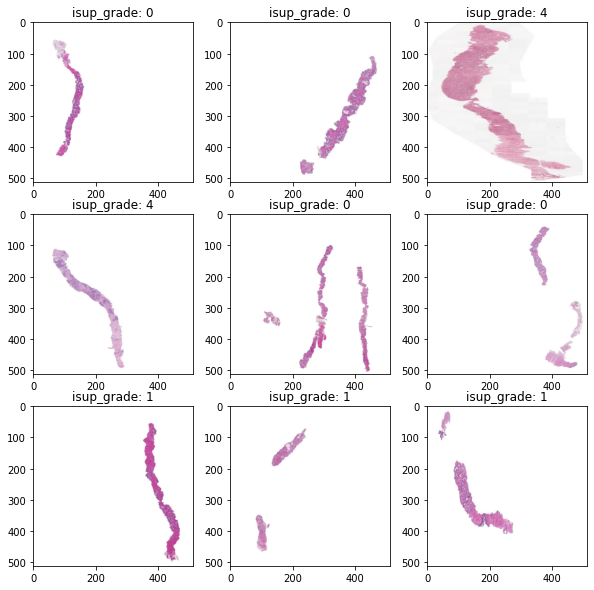

In [7]:
#Plot some slides
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    img=MultiImage(os.path.join(main_path,'train_images',train_df.loc[i-1,'image_id']+'.tiff'))
    img = resize(img[-1], (512, 512))
    fig.add_subplot(rows,cols,i)
    plt.imshow(img)
    plt.title('isup_grade: '+str(train_df.loc[i-1,'isup_grade']))
plt.show()

**Convert and save images**

In [8]:
#for id_ in tqdm(train_df['image_id']):
#    img=MultiImage(os.path.join(main_path,'train_images',id_+'.tiff'))
#    img = resize(img[-1], (1024, 1024))
#    imsave(id_+'.jpg',img)

In [9]:
colums=['image_id','isup_grade']
train_df,val_df=train_test_split(train_df[colums],test_size=0.15)
print('Train shape: {}'.format(train_df.shape))
print('Validation shape: {}'.format(val_df.shape))

Train shape: (9023, 2)
Validation shape: (1593, 2)


**Generator**

In [10]:
class Generator(Sequence):
    def __init__(self,input_data,batch_size=BATCH_SIZE,dims=image_dim,is_shuffle=True,n_classes=6,is_train=True):
        self.image_ids=input_data[0]
        self.labels=input_data[1]
        self.batch_size=batch_size
        self.dims=image_dim
        self.shuffle=is_shuffle
        self.n_classes=n_classes
        self.is_train=is_train
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.image_ids) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        image_ids_temp = [self.image_ids[k] for k in indexes]
        labels_temp = [self.labels[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(image_ids_temp,labels_temp)

        return X, y
    
    def augment_flips_color(self,p=.5):
        return Compose([
            Flip(),
            RandomRotate90(),
            Transpose(),
            HorizontalFlip(),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
            Blur(blur_limit=3),
        ], p=p)
    
    def __data_generation(self, list_IDs_temp,lbls):
        X = np.zeros((self.batch_size, *self.dims))
        y = np.zeros((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img=MultiImage(os.path.join(main_path,'train_images',ID+'.tiff'))
            img = resize(img[-1], (self.dims[0], self.dims[1]))
            #Augmentation
            if self.is_train:
                aug = self.augment_flips_color(p=1)
                img = aug(image=img)['image']
                
            X[i] = img

            # Store class
            y[i] = lbls[i]

        return X, to_categorical(y, num_classes=self.n_classes)

In [11]:
train_gen=Generator([train_df['image_id'].values,train_df['isup_grade'].values])
val_gen=Generator([val_df['image_id'].values,val_df['isup_grade'].values],is_shuffle=False,is_train=False)

In [12]:
from keras.callbacks import Callback
class QWKEvaluation(Callback):
    def __init__(self, validation_data=(), batch_size=BATCH_SIZE, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.batch_size = batch_size
        self.valid_generator, self.y_val = validation_data
        self.history = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_generator(generator=self.valid_generator,
                                                  steps=np.ceil(float(len(self.y_val)) / float(self.batch_size)),
                                                  workers=1, use_multiprocessing=False,
                                                  verbose=1)
            def flatten(y):
                return np.argmax(y, axis=1).reshape(-1)
            
            score = cohen_kappa_score(self.y_val,
                                      flatten(y_pred),
                                      labels=[0,1,2,3,4,5],
                                      weights='quadratic')
            print("\n epoch: %d - QWK_score: %.6f \n" % (epoch+1, score))
            self.history.append(score)
            if score >= max(self.history):
                print('saving checkpoint: ', score)
                self.model.save('classifier.h5')

In [13]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_df['isup_grade']),
                                                   train_df['isup_grade'])

In [14]:
qwk = QWKEvaluation(validation_data=(val_gen, np.asarray(val_df['isup_grade'][:val_gen.__len__()*BATCH_SIZE])),
                    batch_size=BATCH_SIZE, interval=1)

In [15]:
#Model     
inp=Input(shape=image_dim)

base_model=base_model=efn.EfficientNetB6(weights='imagenet',include_top=False,input_tensor=inp)

for layer in base_model.layers:
    layer.trainable=True

feat=GlobalAveragePooling2D()(base_model.output)
out=Dense(6,activation='sigmoid')(feat)
model=Model(inp,out)
model.compile(loss='binary_crossentropy',optimizer=Adam(0.001),metrics=['acc'])

165527552/165527152 [==============================] - 12s 0us/step


In [16]:
history=model.fit_generator(train_gen,epochs=EPOCHS,steps_per_epoch=train_gen.__len__(),validation_data=val_gen,
                    validation_steps=val_gen.__len__(),
                    callbacks=[qwk],class_weight=class_weights)

Epoch 1/6
99/99 [==============================] - 478s 5s/step

 epoch: 1 - QWK_score: 0.384285 

saving checkpoint:  0.38428471199279113
Epoch 2/6
99/99 [==============================] - 478s 5s/step

 epoch: 2 - QWK_score: 0.560583 

saving checkpoint:  0.5605827862365345
Epoch 3/6
99/99 [==============================] - 482s 5s/step

 epoch: 3 - QWK_score: 0.480648 

Epoch 4/6
99/99 [==============================] - 480s 5s/step

 epoch: 4 - QWK_score: 0.499331 

Epoch 5/6
99/99 [==============================] - 475s 5s/step

 epoch: 5 - QWK_score: 0.537217 

Epoch 6/6
99/99 [==============================] - 473s 5s/step

 epoch: 6 - QWK_score: 0.533636 



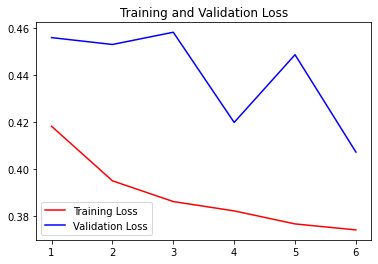

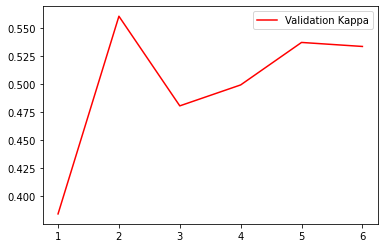

<Figure size 432x288 with 0 Axes>

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
score=qwk.history
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'b',color='red',label='Training Loss')
plt.plot(epochs,val_loss,'b',color='blue',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()
plt.plot(epochs,score,'b',color='red',label='Validation Kappa')
plt.legend()
plt.figure()
plt.show()

In [18]:
del train_gen,val_gen,train_df,val_df

**Test Prediction**

In [19]:
test_dir='../input/prostate-cancer-grade-assessment/test_images'
if os.path.exists(test_dir):
    model=load_model('classifier.h5')
    predicted=[]
    for ID in test_df['image_Id']:
        img=MultiImage(os.path.join(test_dir,ID+'.tiff'))
        img = resize(img[-1], (image_dim[0], image_dim[1]))
        preds=model.predict(np.expand_dims(img,0))
        preds = np.argmax(preds,axis=0)
        predicted.append(preds)
        
    submission=pd.DataFrame({'image_id':test_df['image_id'],'isup_grade':predicted})
    submission.to_csv('submission.csv',index=False)